In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import seaborn as sns
from train_test_divide import extract_normal, extract_spammers_scrapers
import os

In [2]:
path = os.path.dirname(os.path.abspath("__file__"))
dir = path.replace('notebooks', 'csv_files')
os.chdir(dir)

df_anomaly_train = pd.read_csv('train.csv')
df_anomaly_test = pd.read_csv('test.csv')

anomaly_inputs = ['request_freq', 'avg_tokens', 'longest_consec', 'var_score', 'sequence_time']
#anomaly_inputs = ['avg_tokens', 'var_score', 'longest_consec']

model_if = IsolationForest(contamination=0.002, random_state=42)
model_if.fit(df_anomaly_train[anomaly_inputs])

c:\Users\vhage\Documents\Skolarbete\Exjobb\request-analyzer-model\venv\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.002, random_state=42)

In [4]:
#Code for checking how many spammers and scarpers that are present in test dataset
df_test = pd.read_csv('test.csv')
df_test_spam = extract_spammers_scrapers(df_test)
df_test_spam

,request_freq,avg_tokens,longest_consec,var_score,sequence_time,user


In [5]:
#Code for checking how many normal users that are present in test dataset
df_test_normal = extract_normal(df_test, df_test_spam)
df_test_normal

,request_freq,avg_tokens,longest_consec,var_score,sequence_time,user
2677,456.617930,0.090909,2.0,0.000686,19634.571,user-65
2678,1.616125,2.000000,2.0,0.000949,64.645,user-38
2679,604.458950,0.135802,4.0,0.000624,24178.358,user-38
2680,456.350000,0.086957,3.0,0.000669,20535.750,user-618
2681,1381.511541,0.064327,5.0,0.000603,51115.927,user-135
...,...,...,...,...,...,...
3286,309.708469,0.269231,3.0,0.000681,15175.715,user-884
3287,242.812396,0.275000,5.0,0.000841,11654.995,user-884
3288,499.571400,0.118421,2.0,0.000658,22480.713,user-147
3289,598.277932,0.147727,1.0,0.000962,26324.229,user-147


In [6]:
df_anomaly_test['anomaly_score'] = model_if.decision_function(df_anomaly_test[anomaly_inputs])
df_anomaly_test['anomaly'] = model_if.predict(df_anomaly_test[anomaly_inputs])

#This dataframe will only include anomaly score and anomaly label
df_anomaly_score = df_anomaly_test.loc[:,['anomaly_score', 'anomaly']]
df_anomaly_score['user'] = df_anomaly_test['user']
df_a = df_anomaly_score.loc[df_anomaly_score['anomaly']==-1] 
print(df_a)

"""
Test result:
Using all features:
    Sequence length: 15 with 8917 anomalies
        True positives = 2059
        False positives = 4
        True negatives = 1811
        False negatives = 6858

    Sequence length: 25 with 5351 anomalies
        True positives = 2011
        False positives = 11
        True negatives = 1128
        False negatives = 3340

    Sequence length: 35 with 3822 anomalies
        True positives = 2455
        False positives = 0
        True negatives = 835
        False negatives = 1367

    Sequence length: 45 with 2973 anomalies
        True positives = 1972
        False positives = 0
        True negatives = 672
        False negatives = 1001 

    Sequence length: 55 with 2433 anomalies
        True positives = 2246
        False positives = 0
        True negatives = 567
        False negatives = 187        

    Sequence length: 65 with 2060 anomalies
        True positives = 2060
        False positives =  0
        True negatives = 497
        False nagtives = 0   
"""



      anomaly_score  anomaly        user
9         -0.008268       -1   user-1003
20        -0.000942       -1   user-1003
47        -0.001490       -1   user-1003
62        -0.000489       -1   user-1003
84        -0.001490       -1   user-1003
...             ...      ...         ...
2477      -0.026348       -1   user-1004
2537      -0.000942       -1   user-1004
2562      -0.015330       -1   user-1004
2584      -0.013944       -1   user-1004
2640      -0.019062       -1   user-1004

[755 rows x 3 columns]


'\nTest result:\nUsing all features:\n    Sequence length: 15 with 8917 anomalies\n        True positives = 2059\n        False positives = 4\n        True negatives = 1811\n        False negatives = 6858\n\n    Sequence length: 25 with 5351 anomalies\n        True positives = 2011\n        False positives = 11\n        True negatives = 1128\n        False negatives = 3340\n\n    Sequence length: 35 with 3822 anomalies\n        True positives = 2455\n        False positives = 0\n        True negatives = 835\n        False negatives = 1367\n\n    Sequence length: 45 with 2973 anomalies\n        True positives = 1972\n        False positives = 0\n        True negatives = 672\n        False negatives = 1001 \n\n    Sequence length: 55 with 2433 anomalies\n        True positives = 2246\n        False positives = 0\n        True negatives = 567\n        False negatives = 187        \n\n    Sequence length: 65 with 2060 anomalies\n        True positives = 2060\n        False positives =  0\n

In [40]:
#To check which users thar are flagged as anomalies
print(set(df_a['user'].to_list()))
#print(df_anomaly_test.loc[df_anomaly_test['user']== ' user-693'])

{' user-1003', ' user-1005', ' user-1004'}


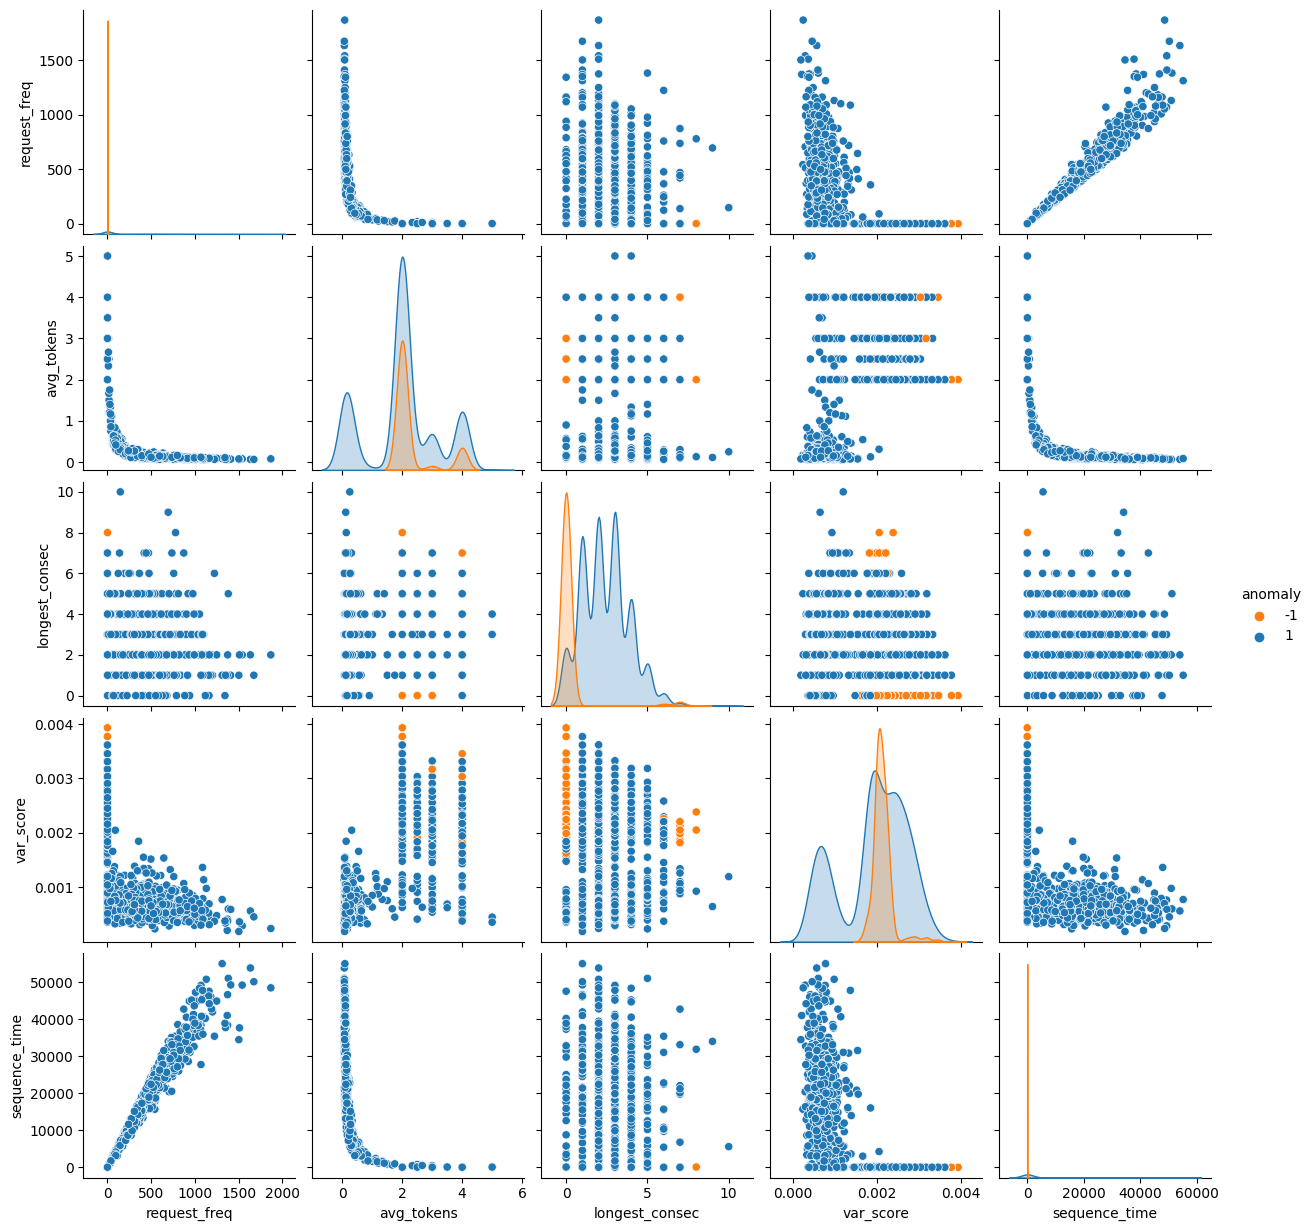

In [7]:
#Plots showcasing the outliers detected by isolation forest
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(df_anomaly_test, vars=anomaly_inputs, hue='anomaly', palette=palette)